In [1]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import six

import random
import time
import os
import gc
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torchvision

TODO:
* [x] Load data from dataset 128
* [x] Implement SEResNeXt training through clean pytorch
* [ ] Add augmentations
* [ ] Add MixUp CutMix
* [ ] Add Cosine LR
* [ ] Try different models
* 

In [3]:
# !pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null # no output

In [4]:
SEED = 1984
BATCH_SIZE = 1  # 128
NUM_EPOCHS = 10
MODEL_NAME ='se_resnext101_32x4d'  #  'se_resnext50_32x4d'  'se_resnext101_32x4d'  # 'wide_resnet50_2'

OUT_PATH = '.'
# TRAIN = '../input/bengali-crop-128x128/'
# LABELS = '../input/bengaliai-cv19/train.csv'

TRAIN = '../input/train/'
LABELS = '../input/train.csv'

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

Custom DataSet

In [6]:
class BengaliAIDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, labels, transform=None):
        self.images_path = images_path
        self.transform = transform
        
        self.labels = labels
        self.image_names = self.labels[:, 0] + '.png'
        self.targets = self.labels[:, 1:4].astype(np.uint8)
    
    def __len__(self):
        """return length of this dataset"""
        return len(self.labels)        
    
    def get_image(self, image_name):
        """
        gets a image by a name gathered from file list text file
        :param name: name of targeted image
        :return: an image
        """
        image_path = os.path.join(self.images_path, image_name)
        image = Image.open(image_path)
#         image = cv2.imread(image_path, 0)
        return image
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        image = self.get_image(image_name)
        
        if self.transform:
            image = self.transform(image)
            
        target = torch.from_numpy(self.targets[index])
        
        return (image, target)

Image transformations

In [7]:
train_transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.0528,), (0.1629,))]) 

Create train dataset with transformations

In [8]:
from sklearn.model_selection import train_test_split

labels = pd.read_csv(LABELS).to_numpy()

labels_train, labels_val = train_test_split(labels, test_size=0.2, stratify=labels[:, 1])

In [9]:
train_dataset = BengaliAIDataset(images_path=TRAIN, labels=labels_train[:10], transform=train_transform)
val_dataset = BengaliAIDataset(images_path=TRAIN, labels=labels_val[:10], transform=train_transform)

Create dataloader from train_dataset

In [10]:
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

dataloaders = {'train': loader_train, 'val': loader_val}

Check loader

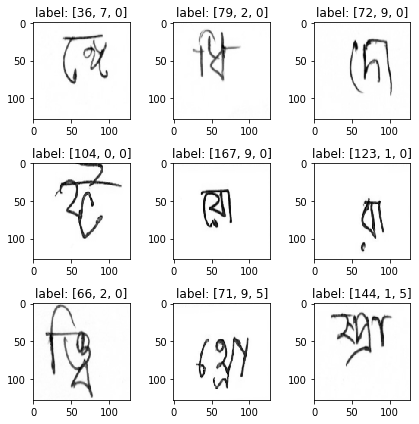

In [11]:
nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(6, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    ax.imshow(image.reshape((128, 128)), cmap='Greys')
    ax.set_title(f'label: {label.data.tolist()}')

plt.tight_layout()
plt.show()

## Model

In [12]:
import pretrainedmodels
from torch import nn
import torch.nn.functional as F

import copy

In [13]:
from sklearn.metrics import recall_score
from ignite.metrics import Recall

In [14]:
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input_x, target, reduction='mean'):
#         x1,x2,x3 = input_x
        x1,x2,x3 = torch.split(input_x, [n_grapheme, n_vowel, n_consonant], dim=1)
        x1,x2,x3 = x1.float(),x2.float(),x3.float()
        y = target.long()
        return 0.7*F.cross_entropy(x1,y[:,0],reduction=reduction) + \
               0.1*F.cross_entropy(x2,y[:,1],reduction=reduction) + \
               0.2*F.cross_entropy(x3,y[:,2],reduction=reduction)

In [15]:
def eval_metric(input_x, target):
    pred = torch.split(input_x, [n_grapheme, n_vowel, n_consonant], dim=1)
    
    recall_grapheme = Recall(average=True)
    recall_vowel = Recall(average=True)
    recall_consonant = Recall(average=True)
    
    recall_grapheme.update((pred[0], target[:, 0].long()))
    recall_vowel.update((pred[1], target[:, 1].long()))
    recall_consonant.update((pred[2], target[:, 2].long()))
    
    res_grapheme = recall_grapheme.compute()
    res_vowel = recall_vowel.compute()
    res_consonant = recall_consonant.compute()

    final_score = np.average([res_grapheme, res_vowel, res_consonant], weights=[2, 1, 1])
    return final_score

In [16]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    history = {'train_loss': list(), 'train_acc': list(), 'val_loss': list(), 'val_acc': list(), }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
 
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += eval_metric(outputs, labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            history['{}_loss'.format(phase)].append(epoch_loss)
            history['{}_acc'.format(phase)].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

> Всем привет. Как вы работаете с размером картинок, который не соответствует размеру, на котором обучались сетки? Вы убираете слои, чтобы картинка не свернулась в тензор с отрицательными Height/Width измерениями? Или есть более хороший способ?

> AdaptiveAvgPool вместо обычного

In [17]:
def get_model(model_name='se_resnext101_32x4d', n_out=186, pretrained='imagenet'):
    if model_name.startswith('se_resnext'):
        model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)

        model.layer0.conv1.in_channels = 1
        model.layer0.conv1.weight.data = model.layer0.conv1.weight.mean(dim=1, keepdim=True)

        model.avg_pool = nn.AvgPool2d(kernel_size=4, stride=1)
        model.last_linear = nn.Linear(in_features=2048, out_features=n_out, bias=True)
    elif model_name.startswith('wide_resnet'):
        model = torch.hub.load('pytorch/vision:v0.5.0', 'wide_resnet50_2', pretrained=True)
        
        model.conv1.in_channels = 1
        model.conv1.weight.data = model.conv1.weight.mean(dim=1, keepdim=True)
        
        model.maxpool = nn.AdaptiveMaxPool2d((112, 112))
        model.fc = nn.Linear(in_features=2048, out_features=n_out, bias=True)
    else:
        raise Exception
    return model

In [18]:
def get_optimizer(model_name='se_resnext101_32x4d'):
    if model_name.startswith('se_resnext'):
        optimizer = torch.optim.Adam(
            [
                {"params": model.layer0.parameters()},
                {"params": model.layer1.parameters()},
                {"params": model.layer2.parameters()},
                {"params": model.layer3.parameters()},
                {"params": model.layer4.parameters()},
                {"params": model.last_linear.parameters(), "lr": 0.005},
            ],
            lr=0.001,
        )
    elif model_name.startswith('wide_resnet'):
        optimizer = torch.optim.Adam(
            [
                {"params": model.conv1.parameters()},
                {"params": model.bn1.parameters()},
                {"params": model.layer1.parameters()},
                {"params": model.layer2.parameters()},
                {"params": model.layer3.parameters()},
                {"params": model.layer4.parameters()},
                {"params": model.fc.parameters(), "lr": 0.005},
            ],
            lr=0.001,
        )
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return optimizer

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

model = get_model(model_name=MODEL_NAME, n_out=n_total)
model = model.to(device)

In [20]:
grad_params = list()
for name, param in model.named_parameters():
    if param.requires_grad == True:
#         print(name)
        grad_params.append(name)
print("N params:", len(grad_params))

N params: 446


In [21]:
optimizer = get_optimizer(MODEL_NAME)

In [22]:
criterion = Loss_combine()

In [23]:
# Train and evaluate
model, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 1/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.10it/s]


train Loss: 4.2284 Acc: 0.0237


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.71it/s]


val Loss: 23.8551 Acc: 0.0182

Epoch 2/10
----------


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.00 GiB total capacity; 941.60 MiB already allocated; 0 bytes free; 72.40 MiB cached)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(hist['train_loss'], label='train_loss');
axes[0].plot(hist['val_loss'], label='val_loss');

axes[1].plot(hist['train_acc'], label='train_acc');
axes[1].plot(hist['val_acc'], label='val_acc');

axes[0].set_title("Loss");
axes[1].set_title("Metric");

axes[0].legend();
axes[1].legend();

In [ ]:
model_path = os.path.join(OUT_PATH, 'seresnext_v0.1.pt')
torch.save(model.state_dict(), model_path)